In [1]:
%pip install "line_profiler[ipython]" ipython==8.5.0 ffmpeg-python imutils==0.5.4 sahi scikit-learn supervision

  Using cached imutils-0.5.4-py3-none-any.whl
  Using cached line_profiler-4.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
INFO: pip is looking at multiple versions of line-profiler[ipython] to determine which version is compatible with other requirements. This could take a while.
  Using cached line_profiler-4.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached line_profiler-4.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached line_profiler-4.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (661 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: /opt/appimages/cursor.AppImage -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
from pathlib import Path

from track import calc_points_new, ignore_detections_from_mask

detections_path = "/notebooks/source/detect/2023-10-22 21h 03m 39s_detections.npy"
loaded_detections = np.load(detections_path, allow_pickle=True)

detections_dir, detections_name = os.path.split(detections_path)
detections_dir = detections_dir or os.getcwd()

points_name = Path(detections_path).stem + '_points.npy'
points_path = os.path.join(detections_dir, points_name)

# ignore_mask_path = ""
# loaded_detections = ignore_detections_from_mask(loaded_detections, ignore_mask_path)

points = calc_points_new(loaded_detections, canvas_width = 1920, canvas_height = 1440)

np.save(points_path, points)

In [3]:
%load_ext line_profiler
import numpy as np
import cv2
from tqdm import tqdm

from render import ffmpeg_read_process, ffmpeg_write_frame

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def decay_heatmap(heatmap, decay_lookup):
    non_zero_indices = heatmap != 0

    clipped_values = heatmap[non_zero_indices]
    
    heatmap[non_zero_indices] = decay_lookup[clipped_values]

    return heatmap

def update_heatmap(heatmap, boxes, intensity_increase):
    h, w = heatmap.shape

    for (x1, y1, x2, y2) in boxes:
        max_side = max((x2 - x1), (y2 - y1))
        
        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2

        pad = max_side * (area_influence ** 0.5 - 1) / 2
        
        tlx, tly, brx, bry = (
            int(max(center_x - max_side / 2 - pad, 0)),
            int(max(center_y - max_side / 2 - pad, 0)),
            int(min(center_x + max_side / 2 + pad, w)),
            int(min(center_y + max_side / 2 + pad, h))
        )
        
        # Create a grid of x, y coordinates
        x_grid, y_grid = np.meshgrid(np.arange(tlx, brx), np.arange(tly, bry))

        # Calculate distance from the center
        distance = np.sqrt((x_grid - center_x) ** 2 + (y_grid - center_y) ** 2)

        # Calculate Gaussian intensity based on distance from the center
        sigma = pad / 3.5 # Standard deviation of the Gaussian
        gaussian_intensity_x = gaussian(x_grid, center_x, sigma)
        gaussian_intensity_y = gaussian(y_grid, center_y, sigma)
        gaussian_intensity = gaussian_intensity_x * gaussian_intensity_y * intensity_increase

        # Update the heatmap
        heatmap[tly:bry, tlx:brx] += gaussian_intensity.astype(np.uint16)

    return heatmap

def find_max(heatmap):
    # Flatten the heatmap and find the index of the maximum value
    max_index_flat = np.argmax(heatmap)
    
    # Convert the index back to 2D coordinates
    max_coord = np.unravel_index(max_index_flat, heatmap.shape)
    
    # Get the actual maximum value
    max_value = heatmap[max_coord]

    return max_coord, max_value

def heatmap_to_frame(heatmap):
    normalized_heatmap = np.minimum(heatmap / (decay_resolution - 1), 1)

    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return cv2.applyColorMap(scaled_heatmap, cv2.COLORMAP_TURBO)

canvas_height = 1440
canvas_width = 1920

decay_resolution = 1024
decay_rate = 256
decay_attack = 4

intensity_increase = decay_rate

area_influence = 400

render = False
render_downscale = 4

def run():
    # Load detections
    detections_path = "/notebooks/samples/detect_v4/sample_detections.npy"
    detections_path = "/notebooks/source/2023_11_29_team_ama/detect_bk/2023-11-29 21h 41m 27s_detections.npy"
    #detections_path = "/notebooks/source/2023_11_29_team_ama/detect_bk/2023-11-29 22h 01m 27s_detections.npy"
    loaded_detections = np.load(detections_path, allow_pickle=True)
    print(f"Loaded {len(loaded_detections)} frames of detections")

    nprange = np.arange(decay_resolution)

    # Precompute cube root values for integers 0 to decay_resolution
    decay_factors = (nprange ** decay_attack) / ((len(nprange) - 1) ** decay_attack) * decay_rate
    decay_lookup = np.clip(nprange - decay_factors, 0, decay_resolution - 1).astype(np.uint16)

    # Initialize an empty list to store heatmaps
    current_heatmap = np.zeros((canvas_height, canvas_width), dtype=np.uint16)  # Use NumPy array

    if render:
        process = ffmpeg_read_process('heatmap.mp4', canvas_width // render_downscale, canvas_height // render_downscale, preset='ultrafast')
    else:
        pbar = tqdm(total=len(loaded_detections))

    max = 9000

    # Process detections for each frame
    for idx, frame_detections in enumerate(loaded_detections):
        if idx > max:
            break

        bounding_boxes = [d['bbox'] for d in frame_detections if d['confidence'] > 0.5]

        decay_heatmap(current_heatmap, decay_lookup)
        update_heatmap(current_heatmap, bounding_boxes, intensity_increase)
        np.clip(current_heatmap, 0, decay_resolution - 1, current_heatmap)

        if render:
            frame = heatmap_to_frame(current_heatmap)

            max_coord, max_value = find_max(current_heatmap)

            cv2.line(frame, (max_coord[1] - 10, max_coord[0]), (max_coord[1] + 10, max_coord[0]), (0,0,0), 2)
            cv2.line(frame, (max_coord[1], max_coord[0] - 10), (max_coord[1], max_coord[0] + 10), (0,0,0), 2)

            cv2.putText(frame, f"{max_value:.2f}", (max_coord[1] + 4, max_coord[0] + 4), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            
            if render_downscale > 1:
                resized_frame = cv2.resize(frame, (canvas_width // render_downscale, canvas_height // render_downscale))

                ffmpeg_write_frame(process, resized_frame)
            else:
                ffmpeg_write_frame(process, frame)
        else:
            pbar.update(1)

    if render:
        process.stdin.close()
        process.wait()
    
%lprun -f update_heatmap -f decay_heatmap -f heatmap_to_frame -f run -u 0.01 run()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Loaded 35982 frames of detections


  0%|          | 0/35982 [00:00<?, ?it/s] 25%|██▌       | 9001/35982 [03:20<10:02, 44.79it/s]  


Timer unit: 0.01 s

Total time: 47.4361 s
File: /tmp/ipykernel_6351/995505994.py
Function: decay_heatmap at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def decay_heatmap(heatmap, decay_lookup):
    12      9001        431.1      0.0      9.1      non_zero_indices = heatmap != 0
    13                                           
    14      9001       1179.4      0.1     24.9      clipped_values = heatmap[non_zero_indices]
    15                                               
    16      9001       3132.1      0.3     66.0      heatmap[non_zero_indices] = decay_lookup[clipped_values]
    17                                           
    18      9001          0.9      0.0      0.0      return heatmap

Total time: 145.008 s
File: /tmp/ipykernel_6351/995505994.py
Function: update_heatmap at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           def u

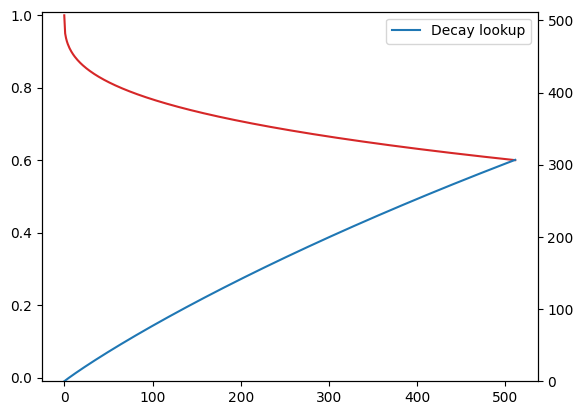

In [14]:
import numpy as np
import matplotlib.pyplot as plt

nprange = np.arange(512)
decay_rate = 0.05

decay_factors = np.clip(1 - (decay_rate * np.cbrt(nprange)), 0, 1)
decay_lookup = np.maximum(nprange * decay_factors, 0)

fig, ax1 = plt.subplots()

ax1.plot(nprange, decay_factors, label='Decay factors', color='tab:red')

ax2 = ax1.twinx()  

ax2.plot(nprange, decay_lookup, label='Decay lookup', color='tab:blue')


# Setting the axis limits
ax1.set_ylim([-0.01, 1.01])
ax2.set_ylim([-0.01, len(nprange) + 0.01])

plt.legend()
plt.show()

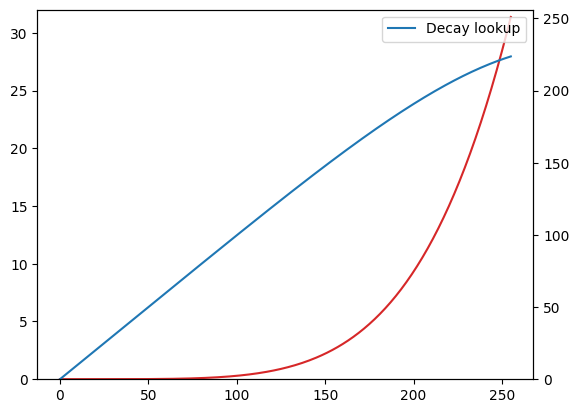

In [30]:
import numpy as np
import matplotlib.pyplot as plt

nprange = np.arange(256)
decay_rate = 32
decay_attack = 5

decay_factors = np.clip((nprange ** decay_attack) / (len(nprange) ** decay_attack), 0, 1) * decay_rate
decay_lookup = np.maximum(nprange - decay_factors, 0)

fig, ax1 = plt.subplots()

ax1.plot(nprange, decay_factors, label='Decay factors', color='tab:red')

ax2 = ax1.twinx()  

ax2.plot(nprange, decay_lookup, label='Decay lookup', color='tab:blue')


# Setting the axis limits
ax1.set_ylim([-0.01, decay_rate + 0.01])
ax2.set_ylim([-0.01, len(nprange)])

plt.legend()
plt.show()

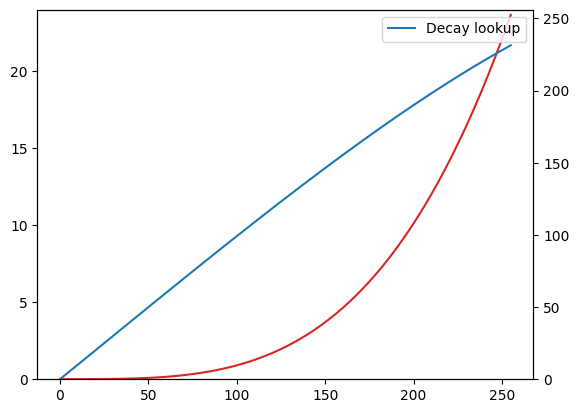

In [22]:
import numpy as np
import matplotlib.pyplot as plt

nprange = np.arange(256)
decay_rate = 24
decay_attack = 3.5

decay_factors = np.clip((nprange ** decay_attack) / (len(nprange) ** decay_attack), 0, 1) * decay_rate
decay_lookup = np.maximum(nprange - decay_factors, 0)

fig, ax1 = plt.subplots()

ax1.plot(nprange, decay_factors, label='Decay factors', color='tab:red')

ax2 = ax1.twinx()  

ax2.plot(nprange, decay_lookup, label='Decay lookup', color='tab:blue')


# Setting the axis limits
ax1.set_ylim([-0.01, decay_rate + 0.01])
ax2.set_ylim([-0.01, len(nprange)])

plt.legend()
plt.show()

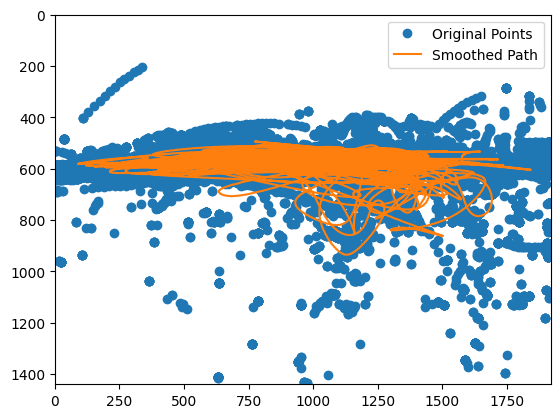

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from core.detections import load_detections
from track import smoothen_pois, calc_points

# Load your points
loaded, loaded_detections = load_detections('/notebooks/source/2023_11_29_team_ama/detect_bk/2023-11-29 22h 01m 27s_detections.npy')

points = calc_points(loaded_detections)

points_smooth = smoothen_pois(points)
x_smooth, y_smooth = zip(*points_smooth)

# Plotting the original and smoothed paths
plt.plot(points[:, 0], points[:, 1], 'o', label='Original Points')
plt.plot(x_smooth, y_smooth, label='Smoothed Path')

# Setting the axis limits
plt.xlim([0, 1920])
plt.ylim([0, 1440])

# Inverting the y-axis to place 0,0 at the top left
plt.gca().invert_yaxis()

plt.legend()
plt.show()

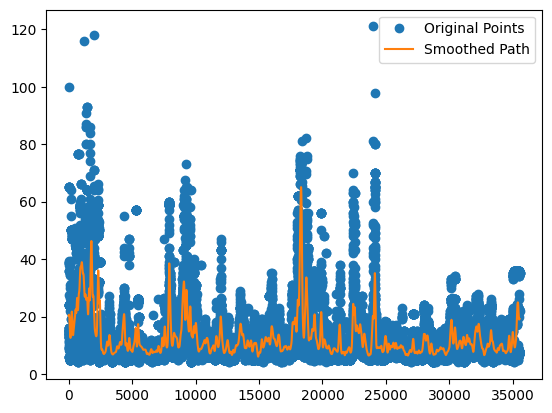

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from render import load_detections
from track import calc_depths, smooth_depths

# Load your points
loaded, loaded_detections = load_detections('/notebooks/source/2023_11_29_team_ama/detect_bk/2023-11-29 22h 21m 28s_detections.npy')

depths = calc_depths(loaded_detections)

depths_smooth = smooth_depths(depths)

# Plotting the original and smoothed paths
plt.plot(depths, 'o', label='Original Points')
plt.plot(depths_smooth, label='Smoothed Path')

plt.legend()
plt.show()

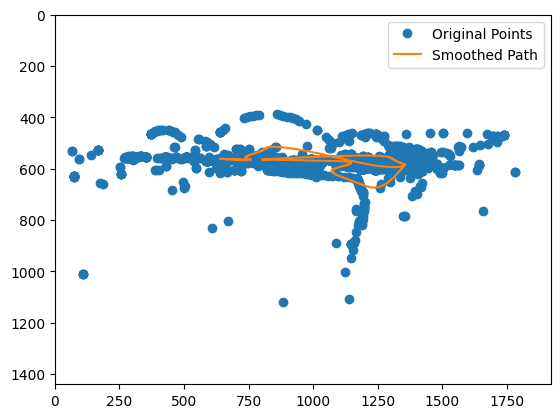

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load your points
loaded_points = np.load('/notebooks/samples/detect/sample_game_points.npy')
points = np.array(loaded_points)

# Apply the Gaussian filter separately to the x and y coordinates
sigma = 60  # This is the standard deviation for the Gaussian kernel, adjust as needed
x_smooth = gaussian_filter1d(points[:, 0], sigma)
y_smooth = gaussian_filter1d(points[:, 1], sigma)

# Plotting the original and smoothed paths
plt.plot(points[:, 0], points[:, 1], 'o', label='Original Points')
plt.plot(x_smooth, y_smooth, label='Smoothed Path')

# Setting the axis limits
plt.xlim([0, 1920])
plt.ylim([0, 1440])

# Inverting the y-axis to place 0,0 at the top left
plt.gca().invert_yaxis()

plt.legend()
plt.show()

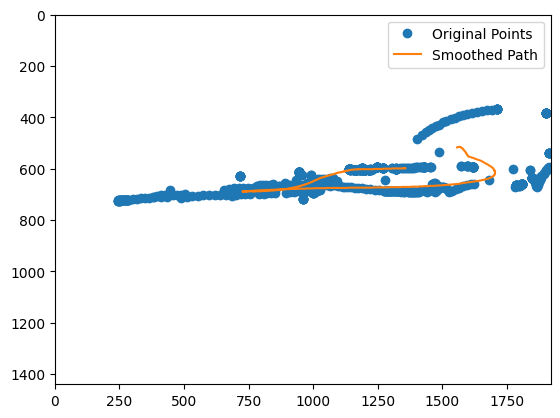

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

def skewed_gaussian_kernel(sigma, kernel_size, skew_factor):
    # Generate a standard Gaussian kernel (symmetric)
    x = np.linspace(-kernel_size, kernel_size, 2 * kernel_size + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))

    # Apply skewness: Reduce the weight of future values
    kernel[x > 0] *= skew_factor  # Reduce weights for future values (x > 0)

    # Normalize the kernel
    kernel /= np.sum(kernel)
    return kernel

def apply_skewed_filter(data, sigma, kernel_size, skew_factor):
    kernel = skewed_gaussian_kernel(sigma, kernel_size, skew_factor)
    smoothed_data = convolve1d(data, kernel, mode='reflect')
    return smoothed_data

# Example usage
sigma = 60
kernel_size = 480
skew_factor = 0.7

loaded_points = np.load('/notebooks/samples/detect_old/sample_points.npy')
points = np.array(loaded_points)

x_smooth = apply_skewed_filter(points[:, 0], sigma, kernel_size, skew_factor)
y_smooth = apply_skewed_filter(points[:, 1], sigma, kernel_size, skew_factor)

# Plotting the original and smoothed paths
plt.plot(points[:, 0], points[:, 1], 'o', label='Original Points')
plt.plot(x_smooth, y_smooth, label='Smoothed Path')

# Setting the axis limits
plt.xlim([0, 1920])
plt.ylim([0, 1440])

# Inverting the y-axis to place 0,0 at the top left
plt.gca().invert_yaxis()

plt.legend()
plt.show()

loading detections from ./source/detect/prerender_detections.npy
loaded 112300 detections from ./source/detect/prerender_detections.npy
Number of clusters: 2 (0, -1)


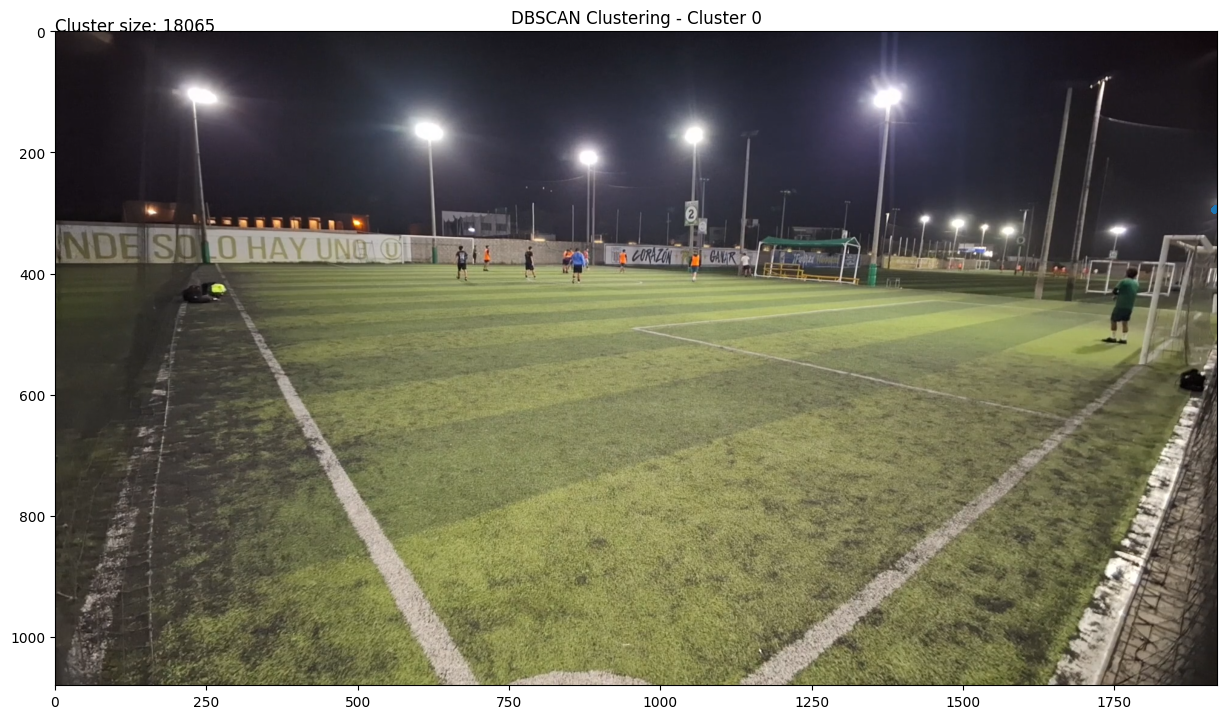

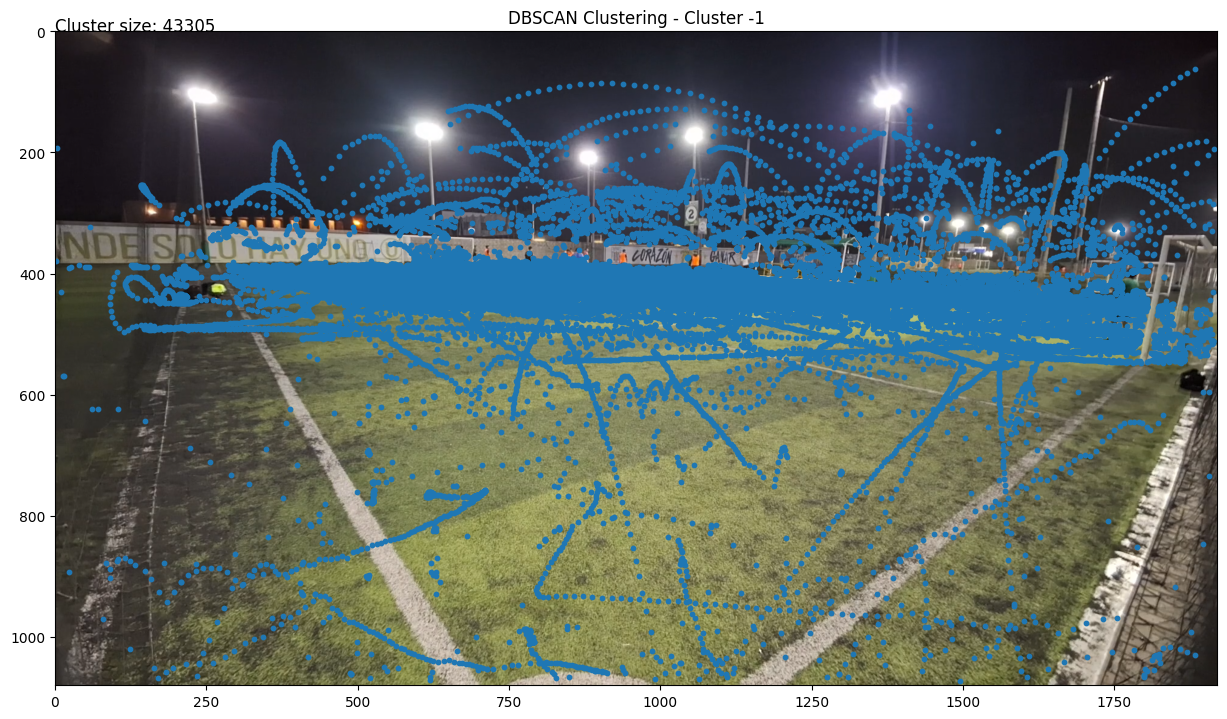

In [1]:
from core.detections import load_video_detections
from track import track_video
import os

os.environ['STATIC_CLUSTER_BACKGROUND_IMAGE'] = './prerender_00:30:43.167.png'
os.environ["CLUSTER_PREVIEW"] = "1"

video_path = "./source/prerender.mp4"
loaded, detections_list = load_video_detections(video_path, module='detect')
filtered_detections = track_video(video_path, detections_list)

del os.environ['CLUSTER_PREVIEW']

#!python tracking.py ./source/prerender.mp4